**IMPORT LIBRARIES**

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np 
import pylab 
import scipy.stats as stats
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

**DATA PROCESSING**

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
plays   = pd.read_csv('/gdrive/My Drive/user_artists.dat',sep='\t')
artists = pd.read_csv('/gdrive/My Drive/artists.dat',sep='\t',usecols=['id','name'])
tags    = pd.read_csv('/gdrive/My Drive/tags.dat', sep='\t',encoding='latin-1')
uta     = pd.read_csv('/gdrive/My Drive/user_taggedartists.dat', sep='\t')
utat    = pd.read_csv('/gdrive/My Drive/user_taggedartists-timestamps.dat', sep="\t")
friends = pd.read_csv('/gdrive/My Drive/user_friends.dat', sep='\t')

In [4]:
#Merge user and artis data
user_artist_data = pd.merge(artists, plays, how='inner', left_on='id', right_on='artistID')
user_artist_data = user_artist_data.rename(columns={"weight":"userArtistPlays"})

user_artist_data.head()

,id,name,userID,artistID,userArtistPlays
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


In [5]:
#Remove rows which doesn't have artist name
if user_artist_data['name'].isnull().sum() > 0:
    user_artist_data = user_artist_data.dropna(axis = 0, subset = ['name'])
    
#Calculate total artist play count
artist_plays = (user_artist_data.groupby(by = ['name'])['userArtistPlays'].sum().reset_index().rename(columns = {'userArtistPlays': 'totalArtistPlays'})[['name', 'totalArtistPlays']])
artist_plays.head()

,name,totalArtistPlays
0,!!!,2826
1,!DISTAIN,1257
2,!deladap,65
3,#####,3707
4,#2 Orchestra,144


In [6]:
#Merge the total play count into the user activity data
user_data_with_artist_plays = user_artist_data.merge(artist_plays, left_on = 'name', right_on = 'name', how = 'left')
user_data_with_artist_plays.head()

,id,name,userID,artistID,userArtistPlays,totalArtistPlays
0,1,MALICE MIZER,34,1,212,771
1,1,MALICE MIZER,274,1,483,771
2,1,MALICE MIZER,785,1,76,771
3,2,Diary of Dreams,135,2,1021,8012
4,2,Diary of Dreams,257,2,152,8012


In [7]:
#Look at the descriptive analysis
pd.set_option('display.float_format', lambda x: '%.3f' % x)
artist_plays['totalArtistPlays'].describe()

count     17632.000
mean       3923.774
std       34099.342
min           1.000
25%         113.000
50%         350.000
75%        1234.250
max     2393140.000
Name: totalArtistPlays, dtype: float64

In [8]:
artist_plays['totalArtistPlays'].quantile(np.arange(.9, 1, .01)), 

(0.900    4645.400
 0.910    5350.680
 0.920    6193.000
 0.930    7320.640
 0.940    8685.280
 0.950   10693.400
 0.960   14257.800
 0.970   18969.740
 0.980   30137.940
 0.990   60096.010
 Name: totalArtistPlays, dtype: float64,)

In [9]:
artist_plays.sort_values(['totalArtistPlays'],ascending=False)

,name,totalArtistPlays
2336,Britney Spears,2393140
3998,Depeche Mode,1301308
8352,Lady Gaga,1291387
3023,Christina Aguilera,1058405
11069,Paramore,963449
9130,Madonna,921198
12072,Rihanna,905423
12818,Shakira,688529
14109,The Beatles,662116
7913,Katy Perry,532545


In [10]:
#Calculate Artisit popularity
x = artist_plays['totalArtistPlays'].max()

artist_rank = (user_data_with_artist_plays.groupby(['name']).agg({'userID':'count','userArtistPlays':'sum'}).
    rename(columns={"userID":'totalUniqueUsers',"userArtistPlays":"totalArtistPlays"}).
              sort_values(['totalArtistPlays'],ascending=False))

artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays']/artist_rank['totalUniqueUsers']
artist_rank.head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Britney Spears,522,2393140,4584.559
Depeche Mode,282,1301308,4614.567
Lady Gaga,611,1291387,2113.563
Christina Aguilera,407,1058405,2600.504
Paramore,399,963449,2414.659


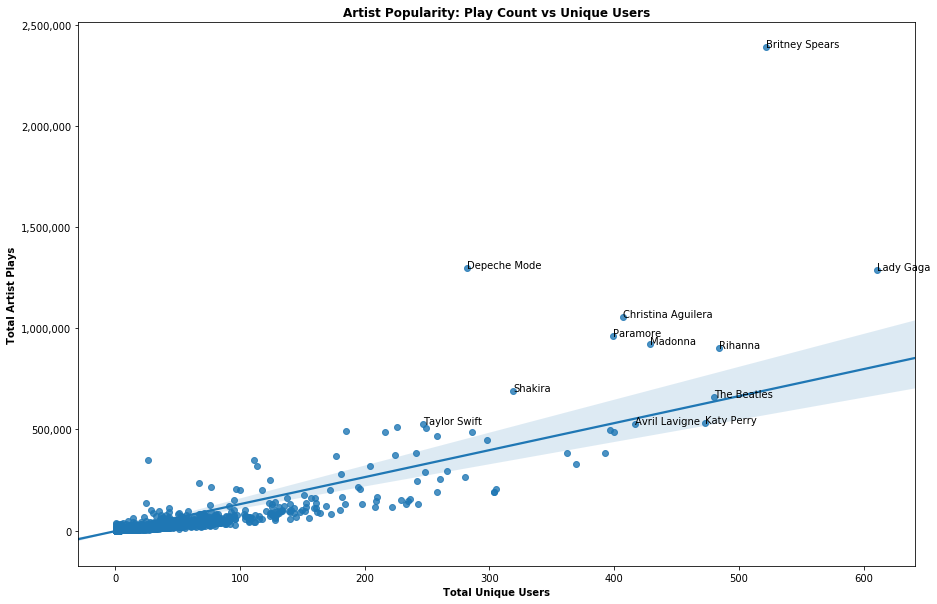

In [11]:
#Plot artist popularity to detect noise data
top_artists = artist_rank.sort_values(['totalArtistPlays'],ascending=False).index[:12]

x = artist_rank.totalUniqueUsers
y = artist_rank.totalArtistPlays
labels = artist_rank.index

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x,y)
ax.set_title('Artist Popularity: Play Count vs Unique Users',fontweight='bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
ax.set_xlabel('Total Unique Users',fontweight='bold')
ax.set_ylabel('Total Artist Plays',fontweight='bold')

for i, t in enumerate(labels):
    if t in top_artists:
        ax.annotate(t,(x[i],y[i]))

In [12]:
#Remove data whose artist play count value is under the threshold
popularity_threshold = 4000
user_data_popular_artists = user_data_with_artist_plays.query('totalArtistPlays >= @popularity_threshold')
user_data_popular_artists.head()

user_data_popular_artists['artistID'].unique().size

1979

In [0]:
#Remove dublicated data which has same userId and artistId

if not user_data_popular_artists[user_data_popular_artists.duplicated(['userID', 'artistID'])].empty:
    initial_rows = user_data_popular_artists.shape[0]

    print('Initial dataframe shape {0}'.format(user_data_popular_artists.shape))
    usa_data = user_data_popular_artists.drop_duplicates(['userID', 'artistID'])
    current_rows = user_data_popular_artists.shape[0]
    print('New dataframe shape {0}'.format(user_data_popular_artists.shape))
    print('Removed {0} rows'.format(initial_rows - current_rows))

**COLLABORATIVE FILTERING**

In [14]:
user_data_popular_artists.head()

,id,name,userID,artistID,userArtistPlays,totalArtistPlays
3,2,Diary of Dreams,135,2,1021,8012
4,2,Diary of Dreams,257,2,152,8012
5,2,Diary of Dreams,325,2,3466,8012
6,2,Diary of Dreams,397,2,56,8012
7,2,Diary of Dreams,560,2,134,8012


In [0]:
#Create artist user sparse matrix for knn implementation
artist_user_data_pivot  = user_data_popular_artists.pivot(index = 'name', columns = 'userID', values = 'userArtistPlays').fillna(0)
artist_user_data_sparse = csr_matrix(artist_user_data_pivot.values)

In [16]:
#Implement Knn model with cosine metrix
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn.fit(artist_user_data_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [0]:
def idx_recommend(data,idx,model,k):
    distances, indices = (model.kneighbors(data.
                                     iloc[idx,:].
                                     values.reshape(1,-1),
                                     n_neighbors=k+1))
  
    nameList = []  
    
    for i in range(0,len(distances.flatten())):
        nameList.append(data.index[indices.flatten()[i]])
      
        if i == 0:
            print(('Recommendations for {}:\n'.
                  format(data.index[idx])))
        else:
            print(('{}: {} ({:.3f})'.
                  format(i,
                         data.index[indices.flatten()[i]],
                         distances.flatten()[i])))
    return nameList

In [18]:
#Item based recommendeation results

seed = np.random.RandomState(seed=42)
query_index = seed.choice(artist_user_data_pivot.shape[0])

indis = idx_recommend(artist_user_data_pivot,query_index,knn,6)


Recommendations for Minor Threat:

1: Otep (0.534)
2: My Bloody Valentine (0.565)
3: Nautilus Pompilius (0.616)
4: Louis Armstrong (0.618)
5: Madball (0.674)
6: Jawbreaker (0.681)


**Content Based Recommendation**

In [19]:
#Find correlated tags for each artist
artist_tags_data= pd.merge(utat, tags, on='tagID', how='left')
artist_tags_data=artist_tags_data[["userID","artistID","tagValue"]]

artist_tags_data = artist_tags_data.drop_duplicates(['artistID', 'tagValue'])

artist_tags_data=artist_tags_data.groupby('artistID')['tagValue'].agg(lambda col: ','.join(col))
artist_tags_data.head()

artistID
1    weeabo,jrock,j-rock,visual kei,better than lad...
2    german,seen live,darkwave,industrial,gothic,am...
3    black metal,norwegian black metal,true norwegi...
4    j-rock,visual kei,metal,gothic japanese,bazaro...
5         gothic,gothic rock,darkwave,deathrock,covers
Name: tagValue, dtype: object

In [0]:
data = artist_tags_data
n_topics = 6
seed = 42
ngram_range = (1,3)
ncols = 2

sw = set(STOPWORDS)

adds = ['rock','pop','hardcore','vocalist','male','female']
for word in adds:
    sw.add(word)

**KMeans Implementation**

In [0]:
n_topics = 7
seed = 42
ngram_range = (1,3)
ncols = 2
data = artist_tags_data


#TfIdf Implementation for the data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data)


In [0]:
nmf = NMF(n_components=n_topics, random_state=seed, alpha=.1, l1_ratio=.5, init='nndsvd')
X_reduced = nmf.fit_transform(X)

In [0]:
# plot K Means Clusters Silhouette and Clusters Analysis
ns = np.arange(2, 20, 1)
inertias = []
silhouettes = []
for n in ns:
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=seed).fit(X_reduced)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    ss = silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000, random_state=seed)
    silhouettes.append(ss)

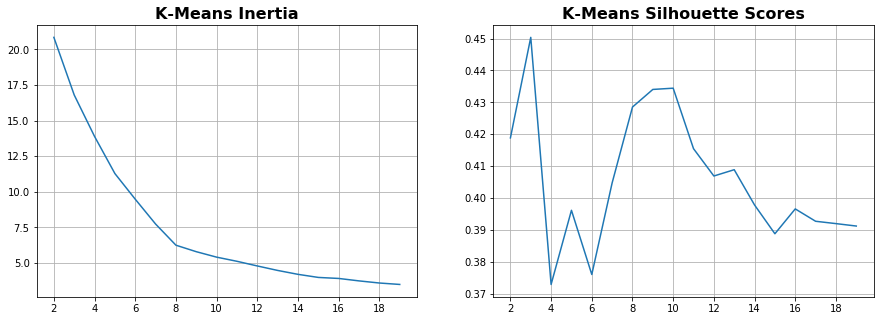

In [25]:
# plot the inertia scores
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)

plt.plot(ns, inertias)
plt.xticks(np.arange(min(ns), max(ns)+1, 2.0))
plt.xlabel = 'Clusters'
plt.ylabel = 'SSE'
plt.title('K-Means Inertia', fontweight='bold',fontsize=16)
plt.grid()

# plot the silhouette scores
ax = fig.add_subplot(1,2,2)

plt.plot(ns, silhouettes)
plt.xticks(np.arange(min(ns), max(ns)+1, 2.0))
plt.xlabel = 'as'
plt.ylabel ='Silhouette Coefficient'
plt.title('K-Means Silhouette Scores', fontweight='bold',fontsize=16)
plt.grid()

In [26]:
#Implementation of KMeans algorithm
kmeans = KMeans(n_clusters=n_topics, init="k-means++", random_state=seed)
kmf = kmeans.fit(X_reduced)
labels = kmf.labels_
ssc = silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000, random_state=seed)

print("Inertia score: {}".format(kmf.inertia_))
print("Silhouette score: {}".format(ssc))
for cluster in range(len(set(labels))):
    print("Cluster {} has {} comments.".format(cluster, sum(labels==cluster)))

Inertia score: 7.733738684829566
Silhouette score: 0.4047317572788124
Cluster 0 has 1631 comments.
Cluster 1 has 1495 comments.
Cluster 2 has 1007 comments.
Cluster 3 has 6155 comments.
Cluster 4 has 525 comments.
Cluster 5 has 955 comments.
Cluster 6 has 755 comments.


In [0]:
X_data_with_clustered = pd.DataFrame(X_reduced)
X_data_with_clustered["Clusters"] = labels

In [58]:
#Combine clusters with artist data
df = data.to_frame()
df["Clusters"] = labels
df

,tagValue,Clusters
artistID,,
1,"weeabo,jrock,j-rock,visual kei,better than lad...",3
2,"german,seen live,darkwave,industrial,gothic,am...",1
3,"black metal,norwegian black metal,true norwegi...",2
4,"j-rock,visual kei,metal,gothic japanese,bazaro...",2
5,"gothic,gothic rock,darkwave,deathrock,covers",3
6,"black metal,gothic metal,doom metal,dark metal...",2
7,"industrial pop,seen live,industrial rock,child...",0
8,"rock,hard rock - metal,j-rock,visual kei,weeab...",0
9,"industrial,futuremelon,terrorbanana,techno,dar...",1


Text(0.5, 1.0, 'T-SNE Clusters')

<Figure size 720x720 with 0 Axes>

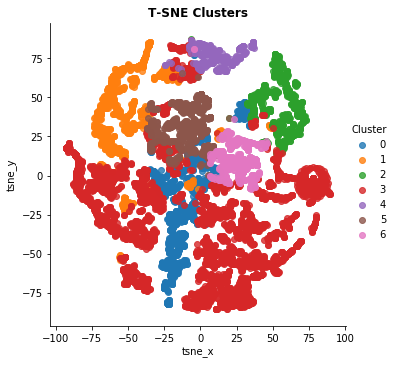

In [29]:
#Tsne for visualizing clusters
tsne = TSNE(n_components=2, init='random',perplexity=30, n_iter=1000, random_state=seed)
trans_data = tsne.fit_transform(X_reduced)
df_tsne = pd.DataFrame(trans_data, columns=["tsne_x", "tsne_y"])
df_tsne["Cluster"] = labels 
df_tsne["Cluster"] = df_tsne["Cluster"].apply(str)


fig = plt.figure(figsize=(10,10))
tsne_sns = sns.lmplot("tsne_x", "tsne_y", data=df_tsne, fit_reg=False, hue="Cluster")

plt.title("T-SNE Clusters",fontweight='bold')

**Hybrid Recommendation**

In [104]:
#Set artist name for recommendation
artistName = "The Beatles"

artistFiltered = artists[artists['name'] == artistName]
artistFiltered

,id,name
294,300,Katy Perry


In [0]:
#Find artists within same cluster with param

df['artistID'] = df.index 
dfFiltered = df[df['artistID'].isin(artistFiltered["id"])]
df_With_Clusters = df[df["Clusters"].isin(dfFiltered["Clusters"])]

In [0]:
user_data_popular_artists_filtered = user_data_popular_artists[user_data_popular_artists["artistID"].isin(df_With_Clusters.artistID)]

In [0]:
user_data_popular_artists_filtered_pivot  = user_data_popular_artists_filtered.pivot(index = 'name', columns = 'userID', values = 'userArtistPlays').fillna(0)

In [109]:
#Make determinant Hybric recommendation

knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn.fit(user_data_popular_artists_filtered_pivot)

names = idx_recommend(user_data_popular_artists_filtered_pivot,artistFiltered.iloc[0, 0],knn,6)


Recommendations for James:

1: The Dandy Warhols (0.257)
2: Chris Cornell (0.481)
3: Edwyn Collins (0.679)
4: The Clientele (0.691)
5: Mark Lanegan (0.729)
6: The Cult (0.798)


In [95]:
artistFiltered.iloc[0, 0]

154